In [1]:
import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline
import matplotlib.pyplot as plt
import pathlib
import geopandas as gpd
import pandas as pd
import xarray as xr
from pyproj import Proj, transform
import sys
sys.path.insert(1, 'Digital-Twins')
sys.path.insert(1, 'Tools')
from src.digitaltwin import setup_environment
from src.lidar import dem_metadata_in_db
from dea_tools.plotting import display_map, rgb

In [3]:
catchment_boundary = dem_metadata_in_db.get_catchment_boundary()
geometry = str(catchment_boundary["geometry"][0])
engine = setup_environment.get_database()
query = "SELECT * FROM model_output WHERE geometry = geometry"
output_data = pd.read_sql_query(query, engine)
output_path = pathlib.Path(output_data['filepath'].values[-1])
print('The latest flood model output path:', output_path)

INFO:2023-02-01 22:42:15,527:src.digitaltwin.setup_environment:Connected to PostgreSQL database!


The latest flood model output path: /home/jovyan/datastorage/model_output/output_2023_02_01_22_41_14.nc


In [4]:
ds = xr.open_dataset(output_path)
ds

<xarray.Dataset>
Dimensions:      (time: 10, blockid: 1728, xx_P0: 768, yy_P0: 576)
Coordinates:
  * time         (time) float32 0.0 100.0 200.0 300.0 ... 700.0 800.0 900.0
  * blockid      (blockid) int32 0 1 2 3 4 5 6 ... 1722 1723 1724 1725 1726 1727
  * xx_P0        (xx_P0) float64 1.569e+06 1.569e+06 ... 1.577e+06 1.577e+06
  * yy_P0        (yy_P0) float64 5.193e+06 5.193e+06 ... 5.199e+06 5.199e+06
Data variables:
    blockxo      (blockid) float32 ...
    blockyo      (blockid) float32 ...
    blockwidth   (blockid) float32 ...
    blocklevel   (blockid) int32 ...
    blockstatus  (blockid) int32 ...
    h_P0         (time, yy_P0, xx_P0) float32 ...
    hmax_P0      (time, yy_P0, xx_P0) float32 ...
    zb_P0        (time, yy_P0, xx_P0) float32 ...
    zs_P0        (time, yy_P0, xx_P0) float32 ...
    u_P0         (time, yy_P0, xx_P0) float32 ...
    v_P0         (time, yy_P0, xx_P0) float32 ...
Attributes:
    maxlevel:  0
    minlevel:  0
    xmin:      1569282.875
    xmax:      1576962.875
    ymin:      5193074.0
    ymax:      5198834.0

In [5]:
x_min, x_max, y_min, y_max = (1569282.875, 1576962.875, 5193074.0, 5198834.0)
x = (x_min, x_max)
y = (y_min, y_max)
crs = 'EPSG:2193'
x, y = transform(Proj(crs), Proj('EPSG:4326'), y, x)
print(x, y)
display_map(x=y, y=x, margin=-0.6)

(-43.41459103482322, -43.363001280864204) (172.62058056973598, 172.71568549167063)


In [6]:
ds = ds.drop(['blockid', 'blockxo', 'blockyo', 'blockwidth', 'blocklevel', 'blockstatus'])
ds = ds.rename({'xx_P0':'x', 'yy_P0':'y'})
ds

<xarray.Dataset>
Dimensions:  (time: 10, x: 768, y: 576)
Coordinates:
  * time     (time) float32 0.0 100.0 200.0 300.0 ... 600.0 700.0 800.0 900.0
  * x        (x) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.577e+06 1.577e+06
  * y        (y) float64 5.193e+06 5.193e+06 5.193e+06 ... 5.199e+06 5.199e+06
Data variables:
    h_P0     (time, y, x) float32 ...
    hmax_P0  (time, y, x) float32 ...
    zb_P0    (time, y, x) float32 ...
    zs_P0    (time, y, x) float32 ...
    u_P0     (time, y, x) float32 ...
    v_P0     (time, y, x) float32 ...
Attributes:
    maxlevel:  0
    minlevel:  0
    xmin:      1569282.875
    xmax:      1576962.875
    ymin:      5193074.0
    ymax:      5198834.0

In [7]:
time_list = list(range(0, 1000, 100))
ds_time = [ds.sel(time=i).drop('time') for i in time_list]

In [8]:
ds_time[0]

<xarray.Dataset>
Dimensions:  (x: 768, y: 576)
Coordinates:
  * x        (x) float64 1.569e+06 1.569e+06 1.569e+06 ... 1.577e+06 1.577e+06
  * y        (y) float64 5.193e+06 5.193e+06 5.193e+06 ... 5.199e+06 5.199e+06
Data variables:
    h_P0     (y, x) float32 ...
    hmax_P0  (y, x) float32 ...
    zb_P0    (y, x) float32 ...
    zs_P0    (y, x) float32 ...
    u_P0     (y, x) float32 ...
    v_P0     (y, x) float32 ...
Attributes:
    maxlevel:  0
    minlevel:  0
    xmin:      1569282.875
    xmax:      1576962.875
    ymin:      5193074.0
    ymax:      5198834.0

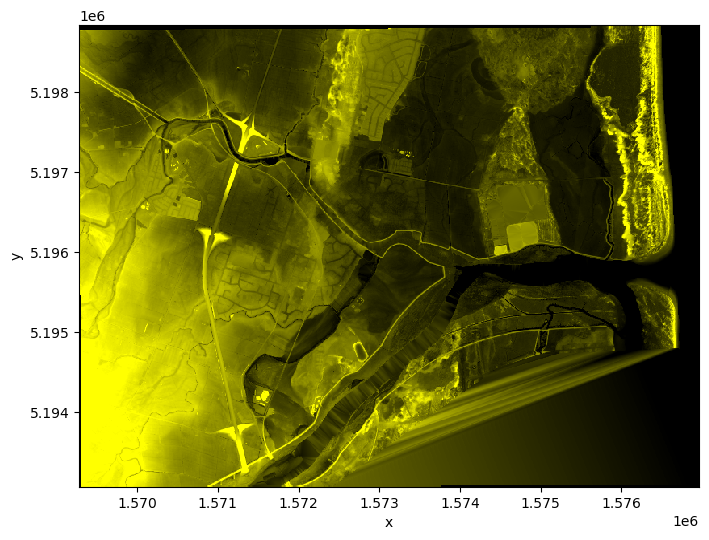

In [9]:
rgb(ds_time[0], bands=['zs_P0', 'zb_P0', 'u_P0'])

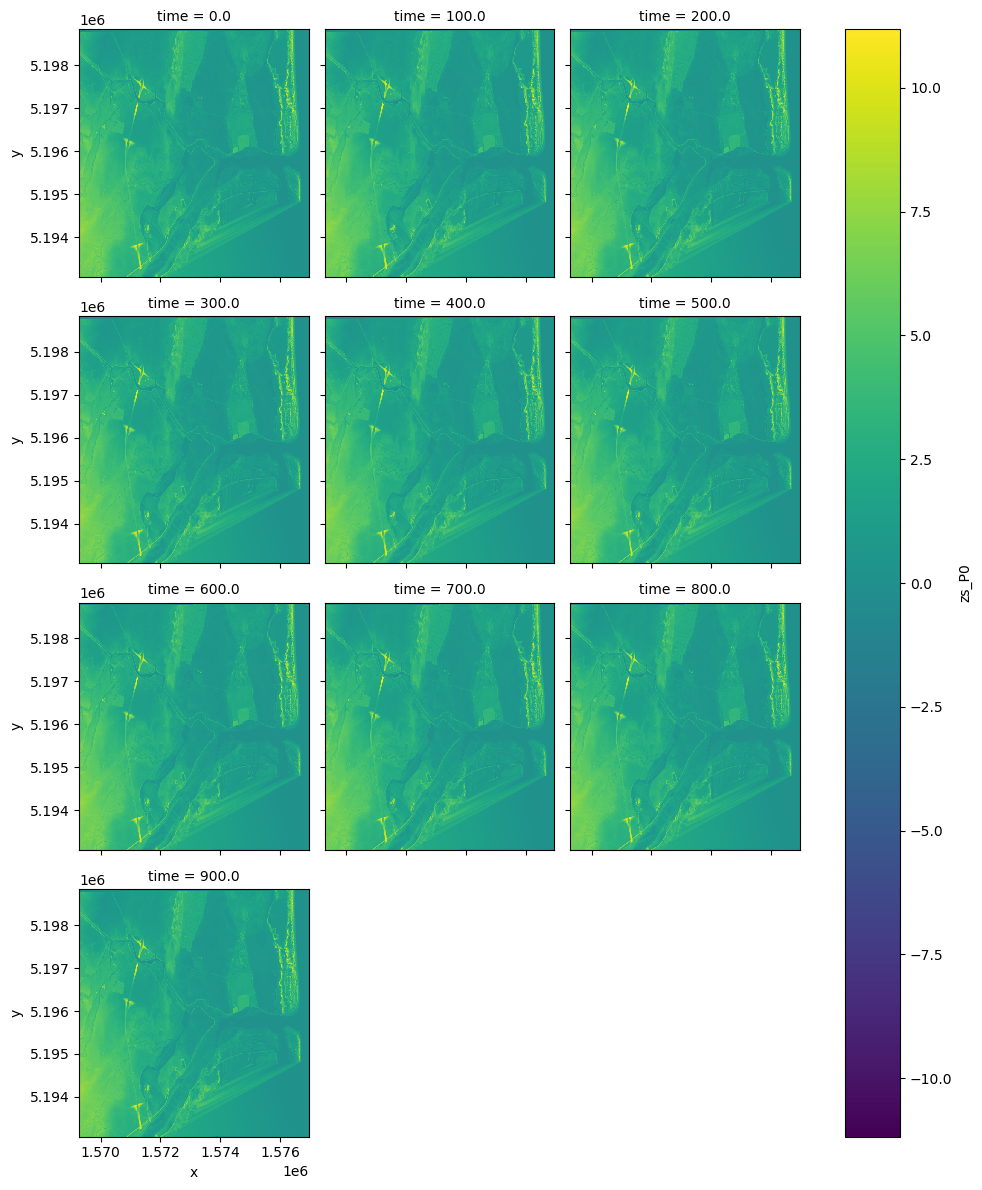

In [10]:
ds.zs_P0.plot(col="time", col_wrap=3, cmap="viridis")
plt.show()